### Creating Dataframes of Different Statistics

##### Creating timeframe

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as md
from matplotlib import ticker
import scipy as scp
import scipy.optimize as opt
import csv
import math
import random
import pandas as pd
import copy
from datetime import datetime, timedelta
import pytz

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

In [2]:
start_date = datetime(2022, 1, 1, 0, 0, 0) #1th of October, 2021, 00:00
start_date = pd.to_datetime(start_date, utc=True)

end_date = datetime(2022, 1, 30, 0, 0, 0) #1st of January, 2022, 00:00
end_date = pd.to_datetime(end_date, utc=True)

dateColumn = pd.date_range(start_date, end_date, freq='D')
dateColumn = pd.DataFrame(dateColumn, columns=['date'])
dateColumn.head()

,date
0,2022-01-01 00:00:00+00:00
1,2022-01-02 00:00:00+00:00
2,2022-01-03 00:00:00+00:00
3,2022-01-04 00:00:00+00:00
4,2022-01-05 00:00:00+00:00


##### Creating LUSD dataframe

In [3]:
LUSD_Utilization = pd.read_csv('bb-USD_data/liquity/LUSD Utilization.csv')
LUSD = pd.DataFrame()

LUSD['date'] = pd.to_datetime(LUSD_Utilization['hour'], utc=True)
LUSD['LUSD in SP'] = LUSD_Utilization['stabilityPool']
#LUSD['LUSD other'] = LUSD_Utilization.iloc[:, 1:].sum(1, numeric_only=True) - LUSD_Utilization['stabilityPool']

LUSD = LUSD.merge(right=dateColumn, on='date', how='right')
LUSD = LUSD.groupby(LUSD['date'].dt.date).mean().reset_index()
LUSD['date'] = pd.to_datetime(LUSD['date'], utc=True)
LUSD.head()

,date,LUSD in SP
0,2022-01-01 00:00:00+00:00,5.187167e+08
1,2022-01-02 00:00:00+00:00,5.182574e+08
2,2022-01-03 00:00:00+00:00,4.992471e+08
3,2022-01-04 00:00:00+00:00,4.997201e+08
4,2022-01-05 00:00:00+00:00,4.875147e+08


##### Creating LQTY dataframe

In [4]:
Total_LQTY_Staked = pd.read_csv('bb-USD_data/liquity/Total LQTY Staked.csv')

LQTY = pd.DataFrame()

LQTY['date'] = pd.to_datetime(Total_LQTY_Staked['hour'], utc=True)
LQTY['LQTY total'] = Total_LQTY_Staked['totalLQTYClaimed']

LQTY = LQTY.merge(right=dateColumn, on='date', how='right')
LQTY = LQTY.fillna(method='bfill')
    
LQTY = LQTY.groupby(LQTY['date'].dt.date).mean().reset_index()
LQTY['date'] = pd.to_datetime(LQTY['date'], utc=True)

LQTY.head()

,date,LQTY total
0,2022-01-01 00:00:00+00:00,1.369321e+07
1,2022-01-02 00:00:00+00:00,1.370822e+07
2,2022-01-03 00:00:00+00:00,1.372906e+07
3,2022-01-04 00:00:00+00:00,1.374768e+07
4,2022-01-05 00:00:00+00:00,1.382611e+07


##### Creating Liquidations dataframe

In [5]:
Liquidations_ = pd.read_csv('bb-USD_data/liquity/Recent Liquidations.csv')

Liquidations = pd.DataFrame()

Liquidations['date'] = pd.to_datetime(Liquidations_['timestamp'], utc=True)
Liquidations['LIQ col'] = Liquidations_['collateral']
Liquidations['LIQ debt'] = Liquidations_['debt']
Liquidations['LIQ price'] = Liquidations_['price']
Liquidations['LIQ CR'] = Liquidations_['collateralRatio']
Liquidations['LIQ mode'] = Liquidations_['mode']
        
Liquidations = Liquidations[(Liquidations['date'] >= start_date) & (Liquidations['date'] <= end_date)].merge(right=dateColumn, on='date', how='outer')
#Liquidations = Liquidations.merge(right=dateColumn, on='date', how='outer')
Liquidations.sort_values(by='date', ignore_index=True, inplace=True)
Liquidations.loc[:, 'LIQ col':'LIQ CR'] = Liquidations.loc[:, 'LIQ col':'LIQ CR'].fillna(value=0)
Liquidations.loc[:, 'LIQ mode'] = Liquidations.loc[:, 'LIQ mode'].fillna(value = 'none')
#Liquidations = Liquidations[Liquidations['LIQ col'] != 0]

Liquidations.head()

,date,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode
0,2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,none
1,2022-01-02 00:00:00+00:00,0.0,0.0,0.0,0.0,none
2,2022-01-03 00:00:00+00:00,0.0,0.0,0.0,0.0,none
3,2022-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,none
4,2022-01-05 00:00:00+00:00,0.0,0.0,0.0,0.0,none


##### Loading aUSD Data

In [6]:
aUSD_TVL = pd.read_csv('bb-USD_data/balancer/aUSD-TVL.csv')
aUSD_Rewards = pd.read_csv('bb-USD_data/balancer/BAL-Rewards.csv')

aUSD_TVL = aUSD_TVL.rename(columns={'day':'date', 'TVL':'aUSD TVL'})
aUSD_TVL = aUSD_TVL[aUSD_TVL['pool'] == 'BB-A-USD (7b507753)'].drop(columns=['pool'])
aUSD_TVL['date'] = pd.to_datetime(aUSD_TVL['date'], utc=True)

aUSD_Rewards = aUSD_Rewards.rename(columns={'week':'date', 'amount':'BAL Reward'}).reset_index(drop=True)
aUSD_Rewards['date'] = pd.to_datetime(aUSD_Rewards['date'])

aUSD = aUSD_TVL.merge(right=dateColumn, on='date', how='outer')
aUSD = aUSD.merge(right=aUSD_Rewards, on='date', how='outer').sort_values(by='date').reset_index(drop=True)
aUSD = aUSD.fillna(0)
aUSD.head()

,date,aUSD TVL,BAL Reward
0,2021-12-13 00:00:00+00:00,0.0,0.0
1,2021-12-14 00:00:00+00:00,0.0,0.0
2,2021-12-15 00:00:00+00:00,0.0,0.0
3,2021-12-16 00:00:00+00:00,0.0,0.0
4,2021-12-17 00:00:00+00:00,0.0,0.0


## Loading Prices

##### Loading ETH Price

In [7]:
ETHprice = pd.read_csv('bb-USD_data/prices/ETH-Price.csv')
ETHprice.drop(ETHprice.loc[:, ['market_cap', 'total_volume']], axis=1, inplace=True)
ETHprice['snapped_at'] = pd.to_datetime(ETHprice['snapped_at'], utc=True )
ETHprice = ETHprice.sort_values(by='snapped_at', ascending=True, ignore_index=True)
ETHprice.rename(columns = {'snapped_at':'date', 'price':'ETH Price'}, inplace=True)
ETHprice = ETHprice.merge(right=dateColumn, how='outer')
ETHprice = ETHprice[(ETHprice['date'] >= start_date) & (ETHprice['date'] <= end_date)].sort_values(by='date').reset_index(drop=True).fillna(method='ffill')
ETHprice = ETHprice.groupby(ETHprice['date'].dt.date).mean().reset_index()
ETHprice['date'] = pd.to_datetime(ETHprice['date'], utc=True)
ETHprice.head()

,date,ETH Price
0,2022-01-01 00:00:00+00:00,3686.402542
1,2022-01-02 00:00:00+00:00,3780.315874
2,2022-01-03 00:00:00+00:00,3835.395991
3,2022-01-04 00:00:00+00:00,3769.404940
4,2022-01-05 00:00:00+00:00,3794.908130


##### Loading BAL Price

In [8]:
BALprice = pd.read_csv('bb-USD_data/prices/BAL-Price.csv')
BALprice = BALprice.loc[:, ('snapped_at', 'price')].rename(columns={'snapped_at': 'date', 'price':'BAL Price'})
BALprice.loc[:, 'date'] = pd.to_datetime(BALprice['date'])
BALprice = BALprice.merge(right=dateColumn, how='outer', on='date')
BALprice = BALprice.sort_values(by='date', ignore_index=True)
BALprice = BALprice[(BALprice['date'] >= start_date) & (BALprice['date'] <= end_date)].fillna(method='ffill')
BALprice = BALprice.reset_index(drop=True)
BALprice = BALprice.groupby(BALprice['date'].dt.date).mean().reset_index()
BALprice['date'] = pd.to_datetime(BALprice['date'], utc=True)
BALprice.head()

,date,BAL Price
0,2022-01-01 00:00:00+00:00,17.534129
1,2022-01-02 00:00:00+00:00,18.560330
2,2022-01-03 00:00:00+00:00,19.647651
3,2022-01-04 00:00:00+00:00,19.165084
4,2022-01-05 00:00:00+00:00,19.409248


##### Loading LQTY Price

In [9]:
LQTYprice = pd.read_csv('bb-USD_data/prices/LQTY-Price.csv')
LQTYprice = LQTYprice.loc[:, ('snapped_at', 'price')].rename(columns={'snapped_at':'date', 'price':'LQTY Price'})
LQTYprice['date'] = pd.to_datetime(LQTYprice['date'])
LQTYprice = LQTYprice.merge(right=dateColumn, how='outer', on='date')
LQTYprice = LQTYprice.sort_values(by='date', ignore_index=True)
LQTYprice = LQTYprice[(LQTYprice['date'] >= start_date) & (LQTYprice['date'] <= end_date)].fillna(method='ffill')
LQTYprice = LQTYprice.reset_index(drop=True)
LQTYprice = LQTYprice.groupby(LQTYprice['date'].dt.date).mean().reset_index()
LQTYprice['date'] = pd.to_datetime(LQTYprice['date'], utc=True)
LQTYprice.head()

,date,LQTY Price
0,2022-01-01 00:00:00+00:00,5.045869
1,2022-01-02 00:00:00+00:00,5.369468
2,2022-01-03 00:00:00+00:00,4.984399
3,2022-01-04 00:00:00+00:00,4.757127
4,2022-01-05 00:00:00+00:00,4.685611


##### Loading Gas Prices

Gas Prices are loaded in ETH

In [10]:
Gas = pd.read_csv('bb-USD_data/prices/GAS-Price.csv')

Gas['Date(UTC)'] = pd.to_datetime(Gas['Date(UTC)'], utc=True)
Gas = Gas.drop(columns=['UnixTimeStamp']).rename(columns={'Date(UTC)':'date', 'Value (Wei)':'GAS Price'})
Gas = Gas[(Gas['date'] >= start_date) & (Gas['date'] <= end_date)]
Gas['GAS Price'] = Gas['GAS Price'] / 10**18
Gas.head()

,date,GAS Price
2347,2022-01-01 00:00:00+00:00,8.136064e-08
2348,2022-01-02 00:00:00+00:00,1.005875e-07
2349,2022-01-03 00:00:00+00:00,1.078230e-07
2350,2022-01-04 00:00:00+00:00,1.331729e-07
2351,2022-01-05 00:00:00+00:00,1.492867e-07


## Loading Swaps on Curve and Uniswap

In [11]:
Curve_TVL = pd.read_csv('bb-USD_data/dex/Curve-LUSD-TVL.csv')
Curve_Volume = pd.read_csv('bb-USD_data/dex/Curve-LUSD-Volume.csv')

Curve_TVL['Curve TVL'] = Curve_TVL['3crvBalance'] + Curve_TVL['lusdBalance']
Curve_TVL = Curve_TVL.rename(columns={'hour':'date'})[['date', 'Curve TVL']]
Curve_TVL['date'] = pd.to_datetime(Curve_TVL['date'], utc=True)
Curve_TVL = Curve_TVL.groupby(Curve_TVL['date'].dt.date).mean().reset_index()
Curve_TVL['date'] = pd.to_datetime(Curve_TVL['date'], utc=True)

Curve_Volume = Curve_Volume.rename(columns={'day':'date', 'lusd':'Curve Volume'})
Curve_Volume['date'] = pd.to_datetime(Curve_Volume['date'], utc=True)
Curve_Volume = Curve_Volume.groupby(Curve_Volume['date'].dt.date).sum().reset_index()
Curve_Volume['date'] = pd.to_datetime(Curve_Volume['date'], utc=True)

Curve = Curve_TVL.merge(right=Curve_Volume, on='date', how='outer').sort_values(by='date').reset_index(drop=True)
Curve['Curve TVL'] = Curve['Curve TVL'].fillna(method='ffill')
Curve['Curve Volume'] = Curve['Curve Volume'].fillna(0)
Curve['date'] = pd.to_datetime(Curve['date'], utc=True)
Curve = Curve.sort_values(by='date').reset_index(drop=True)
Curve.head()


,date,Curve TVL,Curve Volume
0,2021-04-06 00:00:00+00:00,39702.760262,0.000000
1,2021-04-15 00:00:00+00:00,411790.808724,137245.905938
2,2021-04-16 00:00:00+00:00,535782.387274,27574.609161
3,2021-04-17 00:00:00+00:00,535906.837565,31945.658267
4,2021-04-18 00:00:00+00:00,536556.026508,311672.133194


### Merging All Data into Single Dataframe


##### Creating main dataframe and merging info

In [12]:
Data = pd.DataFrame()
Data = copy.deepcopy(dateColumn)

Data = Data.merge(LUSD, how='outer', on='date')
Data = Data.merge(LQTY, how='outer', on='date')
Data = Data.merge(Liquidations, how='outer', on='date')
Data = Data.merge(ETHprice, on='date', how='outer')
Data = Data.merge(BALprice, on='date', how='outer')
Data = Data.merge(LQTYprice, on='date', how='outer')
Data = Data.merge(aUSD, on='date', how='outer')
Data = Data.merge(Gas, on='date', how='outer')
Data = Data.merge(Curve, on='date', how='outer')

Data = Data[(Data['date'] >= start_date) & (Data['date'] <= end_date)]
Data = Data.sort_values(by=['date'], ignore_index=True).reset_index(drop=True)#.fillna(method='ffill')

#Data[['ETH Price', 'BAL Price', 'LQTY Price']] = Data[['ETH Price', 'BAL Price', 'LQTY Price']].fillna(method='ffill')
#Data[['ETH Price', 'BAL Price', 'LQTY Price']] = Data[['ETH Price', 'BAL Price', 'LQTY Price']].fillna(method='bfill')
#Data[Data.columns.drop(['ETH Price', 'LIQ mode'])] = Data[Data.columns.drop(['ETH Price', 'LIQ mode'])].fillna(method='ffill')

for c in ['LUSD in SP', 'LQTY total', 'ETH Price', 'BAL Price', 'LQTY Price', 'aUSD TVL', 'GAS Price', 'Curve TVL']:
    Data[c].fillna(method='ffill', inplace=True)



for c in ['BAL Reward', 'Curve Volume']:
    Data[c].fillna(value=0, inplace=True)

Data.head()

,date,LUSD in SP,LQTY total,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode,ETH Price,BAL Price,LQTY Price,aUSD TVL,BAL Reward,GAS Price,Curve TVL,Curve Volume
0,2022-01-01 00:00:00+00:00,5.187167e+08,1.369321e+07,0.0,0.0,0.0,0.0,none,3686.402542,17.534129,5.045869,3.027455e+07,0.0,8.136064e-08,1.231912e+08,1.833129e+07
1,2022-01-02 00:00:00+00:00,5.182574e+08,1.370822e+07,0.0,0.0,0.0,0.0,none,3780.315874,18.560330,5.369468,3.027455e+07,0.0,1.005875e-07,1.358944e+08,6.249185e+06
2,2022-01-03 00:00:00+00:00,4.992471e+08,1.372906e+07,0.0,0.0,0.0,0.0,none,3835.395991,19.647651,4.984399,3.114778e+07,5000.0,1.078230e-07,1.523131e+08,3.814049e+06
3,2022-01-04 00:00:00+00:00,4.997201e+08,1.374768e+07,0.0,0.0,0.0,0.0,none,3769.404940,19.165084,4.757127,3.116638e+07,0.0,1.331729e-07,1.638818e+08,6.361206e+06
4,2022-01-05 00:00:00+00:00,4.875147e+08,1.382611e+07,0.0,0.0,0.0,0.0,none,3794.908130,19.409248,4.685611,3.116638e+07,0.0,1.492867e-07,1.823764e+08,1.304679e+07


## Initializing Pool with 50/50 $ 60M Total TVL

### Creating a Pool Dataframe

### Operations Gas Requirement

We take into account the gas price for such operations like ETH, BAL and LQTY withdrawal and Stability Pool liquidity provision.
The respective gas estimations for these operations are:

* SP add liquidity: 300,000
* ETH withdrawal: 500,000
* LQTY withdrawal: 350,000
* BAL withdrawal: 100,000
* Trading operation: 1% fee + gas

### B.Protocol comissions

In case we route the liquidity of LUSD through B.Protocol, we use the following rules (according to B.Protocol policy):

* Comission - 1% (This means 1% of ETH income from liquidations will be paid to B.Protocol)
* ETH price sale - 0-4% (When B.Protocol puts ETH for sale, it allows maximum decrease in price of 4% relative to the market price)

In [13]:
def create_pool(Data):

    Pool_ = pd.DataFrame()
        #columns = ['date', 'LUSD', 'aUSD', 'LQTY', 'ETH', 'SP share', 'ETH received', 'BAL received']
        #)

    Pool_['date'] = Data['date']

    # ---Main balances---
    Pool_.loc[:, 'LUSD'] = 30e6 #LUSD in Pool_
    Pool_.loc[:, 'aUSD'] = 30e6 #aUSD in Pool_

    # ---Pool_ shares---

    # Calculated as (Amount in Pool_) / (Amount in common Pool_)
    # For example,
    # for LUSD share it will be (LUSD in Pool_ (staked)) / (LUSD in Liquity Stability Pool_)
    # for aUSD share it will be (aUSD in Pool_) / (TVL in bb-a-USD Balancer Pool_)
    Pool_.loc[:, 'SP share'] = 0 #Stability Pool_ share
    Pool_.loc[:, 'aUSD share'] = 0 #Balancer aUSD pool_ share

    #Reward tokens balances
    Pool_.loc[:, 'LQTY'] = 0 #LQTY Rewards collected, but not withdrawn
    Pool_.loc[:, 'BAL'] = 0 #BAL Rewards collected, but not withdrawn
    Pool_.loc[:, 'ETH'] = 0 #ETH Rewards collected, but not withdrawn

    #Reward tokens income
    Pool_.loc[:, 'ETH received'] = 0 #ETH received at the timestamp
    Pool_.loc[:, 'BAL received'] = 0 #BAL received at the timestamp
    Pool_.loc[:, 'LQTY received'] = 0 #LQTY received at the timestamp

    #Reward tokens sold
    Pool_.loc[:, 'ETH sold'] = 0 #ETH sold at the timestamp
    Pool_.loc[:, 'BAL sold'] = 0 #BAL sold at the timestamp
    Pool_.loc[:, 'LQTY sold'] = 0 #LQTY sold at the timestamp

    #Trading fees
    #Trading income is calculated as follows: we assume that the trading volume on Curve is split amongst our pool_ and Curve LUSD-3crv pool_
    # Income  = Fee% * Curve Trading Volume * Pool_ TVL / (Pool_ TVL + Curve TVL)
    Pool_.loc[:, 'Trading income'] = 0 # Total income (in USD) from trading operations
    Pool_.loc[:, 'Trading fees'] = 0 # Total fees paid for trading operations (1% of the amount traded (in USD))

    #Gas spendings
    Pool_.loc[:, 'BAL gas'] = 0
    Pool_.loc[:, 'ETH gas'] = 0
    Pool_.loc[:, 'LQTY gas'] = 0
    Pool_.loc[:, 'SP gas'] = 0

    #B.Protocol spendings
    Pool_.loc[:, 'ETH sale'] = 0 # Total losses from ETH being sold with sale (in USD)
    Pool_.loc[:, 'ETH comission'] = 0 # Comission paid to B.Protocol (in USD)

    #DAO fees reserve
    Pool_.loc[:, 'LQTY reserve'] = 0 # LQTY accumulated in PowerPool_ DAO Treasury

    #LUSD burned
    Pool_.loc[:, 'LUSD burn'] = 0 # LUSD in our pool_ that was burned during liquidations


    Pool_ = Pool_.sort_values('date', ignore_index=True).reset_index(drop=True)

    return Pool_

In [14]:
def run(Pool_, BProt = False, sale_ = 0, reserve_ = 0, DAO_fees_ = 0, swaps = False):
    
    # Bring all parameters from percentage to decimal
    sale = sale_/100
    reserve = reserve_/100
    DAO_fees = DAO_fees_/100

    for i in range(len(Pool_)):

        # Bring the previous balances to the current timestamp
        if (i > 0):
            Pool_.loc[i, 'LUSD'] = Pool_['LUSD'][i-1]   
            Pool_.loc[i, 'ETH'] = Pool_['ETH'][i-1]
            Pool_.loc[i, 'aUSD'] = Pool_['aUSD'][i-1]
            Pool_.loc[i, 'LQTY'] = Pool_['LQTY'][i-1]
            Pool_.loc[i, 'BAL'] = Pool_['BAL'][i-1]
            Pool_.loc[i, 'LQTY reserve'] = Pool_['LQTY reserve'][i-1]

        # Calculate shares of the pool_ parts at the timestep
        Pool_.loc[i, 'SP share'] = Pool_['LUSD'][i] / Data['LUSD in SP'][i] * (1 - reserve)
        Pool_.loc[i, 'aUSD share'] = Pool_['aUSD'][i] / Data['aUSD TVL'][i]

        
        # If liquidation occurs, process liquidation gains and LUSD burn
        if (Data['LIQ mode'][i] != 'none'):
            ETH_received = Data['LIQ col'][i]*(1-0.005)*Pool_['SP share'][i]
            LUSD_burned = Data['LIQ debt'][i]*Pool_['SP share'][i]
            Pool_.loc[i, 'ETH received'] = ETH_received
            Pool_.loc[i, 'ETH'] += ETH_received
            Pool_.loc[i, 'LUSD'] -= LUSD_burned
            Pool_.loc[i, 'LUSD burn'] += LUSD_burned
            
        else:
            
            #gas price on the current timestamp (USD per 1 unit of Gas)
            gas_price = Data['GAS Price'][i] * Data['ETH Price'][i]


            # ---Check Pool_ "account" and sell reward tokens if conditions met---

            #checking if any ETH is on the account
            ETH_in_pool_ = Pool_['ETH'][i]

            if (BProt):

                #Using B.Protocol:
                #No gas spendings
                #1% B.Protocol comission
                #0-4% ETH sale

                ETH_sold = ETH_in_pool_ * (1 - 0.01) #1% comission
                ETH_comission = ETH_in_pool_ * 0.01

                LUSD_bought = ETH_sold * Data['ETH Price'][i] * (1 - sale)
                ETH_sale = ETH_sold * Data['ETH Price'][i] * sale

                Pool_.loc[i, 'ETH'] = 0
                Pool_.loc[i, 'LUSD'] += LUSD_bought

                Pool_.loc[i, 'ETH sold'] += ETH_sold

                Pool_.loc[i, 'ETH sale'] += ETH_sale
                Pool_.loc[i, 'ETH comission'] += ETH_comission

            else:

                #LUSD deposit gas: 300,000 gwei
                #ETH withdraw gas: 500,000 gwei

                # We allow gas spendings of up to 10% of the trade volume
                if (ETH_in_pool_ * Data['ETH Price'][i] >= 10 * 500000 * gas_price):
                    
                    ETH_sold = ETH_in_pool_
                    LUSD_bought = ETH_sold * Data['ETH Price'][i] * (1 - 0.01) - 500000 * gas_price #we spend gas to withdraw ETH from Liquity

                    Pool_.loc[i, 'ETH'] = 0
                    Pool_.loc[i, 'LUSD'] += LUSD_bought - 300000 * gas_price #we spend gas to restake LUSD into Stability Pool_

                    Pool_.loc[i, 'ETH sold'] += ETH_sold

                    Pool_.loc[i, 'SP gas'] += 300000 * gas_price
                    Pool_.loc[i, 'ETH gas'] += 500000 * gas_price
                    Pool_.loc[i, 'Trading fees'] += ETH_sold * Data['ETH Price'][i] *  0.01

            #checking if we have enough BAL tokens to sell and add liquidity to the pool_

            # We allow gas spendings of up to 10% of the trade volume
            if (Pool_['BAL'][i] >= 10 * 100000 * gas_price):

                BAL_sold = Pool_['BAL'][i]
                aUSD_bought = BAL_sold * Data['BAL Price'][i] * (1 - 0.01) - 100000 * gas_price #we spend gas to withdraw BAL rewards

                Pool_.loc[i, 'BAL'] = 0
                Pool_.loc[i, 'aUSD'] += aUSD_bought
                
                Pool_.loc[i, 'BAL sold'] += BAL_sold

                Pool_.loc[i, 'BAL gas'] += 100000 * gas_price
                Pool_.loc[i, 'Trading fees'] += BAL_sold * Data['BAL Price'][i] * 0.01
                
                
            #checking if any LQTY is on the account

            if (Pool_['LQTY'][i] > 10 * 350000 * gas_price):

                LQTY_sold = Pool_['LQTY'][i]
                LUSD_bought = LQTY_sold * Data['LQTY Price'][i] * (1 - 0.01) - 350000 * gas_price #we spend gas to withdraw LQTY rewards

                Pool_.loc[i, 'LQTY'] = 0
                Pool_.loc[i, 'LUSD'] += LUSD_bought - 300000 * gas_price #we spend gas to restake LUSD into Stability Pool_

                Pool_.loc[i, 'LQTY sold'] += LQTY_sold

                Pool_.loc[i, 'LQTY gas'] += 350000 * gas_price
                Pool_.loc[i, 'SP gas'] += 300000 * gas_price

                Pool_.loc[i, 'Trading fees'] += LQTY_sold * Data['LQTY Price'][i] * 0.01

            #calculating hypothetical trading volume fees
            # 0.04% fee
            if swaps:
                Trading_volume_income = (Pool_['LUSD'][i] + Pool_['aUSD'][i])/Data['Curve TVL'][i] * Data['Curve Volume'][i] * 0.04 / 100
                # We assume the trading income is split equally between the parts of our pool_
                Pool_.loc[i, 'aUSD'] += Trading_volume_income / 2
                Pool_.loc[i, 'LUSD'] += Trading_volume_income / 2
                Pool_.loc[i, 'Trading income'] += Trading_volume_income
            
                
            # Calculating reward incomes
            
            if (i > 0):
                
                #calculating LQTY reward
                # LQTY rewards = SP share * (LQTY Total Supply (t) - LQTY Total Supply (t-1))

                LQTY_minted = Data['LQTY total'][i] - Data['LQTY total'][i-1]
                Pool_.loc[i, 'LQTY'] += LQTY_minted * Pool_['SP share'][i] * (1 - DAO_fees)
                Pool_.loc[i, 'LQTY received'] += LQTY_minted * Pool_['SP share'][i]
                Pool_.loc[i, 'LQTY reserve'] += LQTY_minted * Pool_['SP share'][i] * DAO_fees

                #calculating aUSD revenue (this part is not accounted for)
                '''fees = Data['aUSD revenues'][i]*Pool_['aUSD share'][i]
                Pool_['aUSD'] += fees'''

                #calculating BAL rewards
                # BAL rewards = aUSD share * aUSD BAL rewards (t)
                BAL_received = Data['BAL Reward'][i] * Pool_['aUSD share'][i]
                Pool_.loc[i, 'BAL received'] = BAL_received
                Pool_.loc[i, 'BAL'] += BAL_received

    return Pool_

In [15]:
BProt = True
Sale = 0
Reserve = 0
DAO_fees = 0
Swaps = True

Pool = create_pool(Data)
Pool_0 = create_pool(Data)
Pool_4 = create_pool(Data)

Pool = run(Pool, False, Sale, Reserve, DAO_fees, Swaps)
Pool_0 = run(Pool_0, True, 0, Reserve, DAO_fees, Swaps)
Pool_4 = run(Pool_4, True, 4, Reserve, DAO_fees, Swaps)

In [16]:
(Pool_4['SP share'] == Pool['SP share']).all()

False

### Data peculiarities

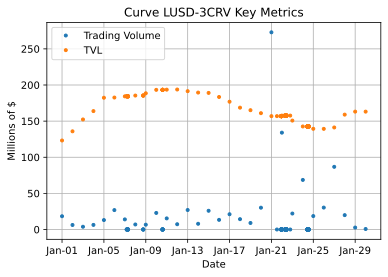

In [17]:
%config InlineBackend.figure_format = 'svg'

plt.plot(Data['date'], Data['Curve Volume'], label='Trading Volume', lw=0, marker='.')
plt.plot(Data['date'], Data['Curve TVL'], label='TVL', lw=0, marker='.')
plt.title('Curve LUSD-3CRV Key Metrics')
plt.xlabel('Date')
plt.ylabel('Millions of $')
plt.legend()

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
plt.gca().yaxis.set_major_formatter(ticks_y)
plt.grid()

date_form = md.DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(date_form)


### Results

In [18]:
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

##### Pool State vs Time:

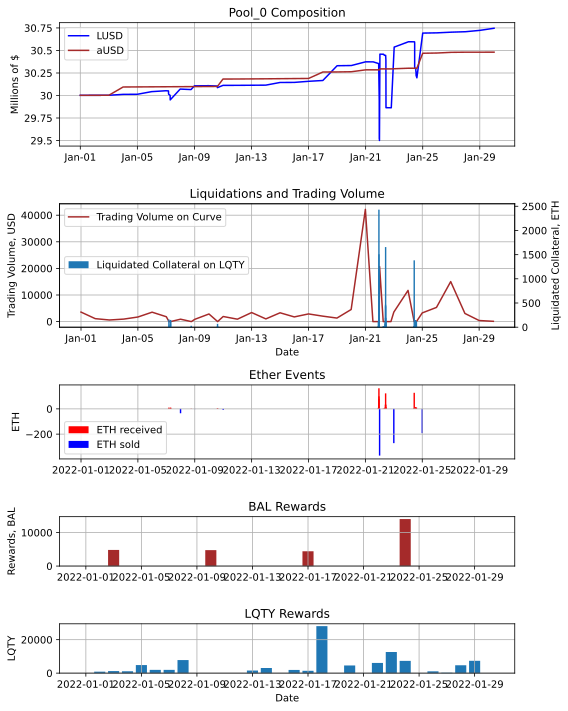

In [19]:
%config InlineBackend.figure_format='svg'
%matplotlib inline

#cut = pd.to_datetime(datetime(2022, 1, 21, 0, 0, 0), utc=True)
#Pool_0 = Pool_0[Pool_0['date'] <= cut]

fig, (ax1, ax5, ax2, ax3, ax4) = plt.subplots(5, 1, gridspec_kw={'height_ratios': [5,5,3,2,2]})
fig = plt.gcf()

dates = np.arange(0, len(Pool_0), 48)
date_ticks = [Pool_0['date'][i] for i in dates]

plot = ax1.plot(Pool_0['date'], Pool_0['LUSD'], color='blue')
plot = ax1.plot(Pool_0['date'], Pool_0['aUSD'], color='brown')
ax1.legend(('LUSD', 'aUSD'))
ax1.grid()
ax1.set(
    title = 'Pool_0 Composition',
    ylabel = 'Millions of $'
)

date_form = md.DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)


ax51 = ax5.twinx()
ax5.plot(Data['date'], Pool_0['Trading income'], color='brown')
#gradient_fill(Data.index.to_numpy(), y=Data['Curve Volume'].to_numpy(), ax=ax51)
ax51.bar(Data['date'], Data['LIQ col'], width=0.1)
ax5.set(
    title='Liquidations and Trading Volume',
    xlabel='Date',
    ylabel='Trading Volume, USD'
)
ax51.set(
    ylabel='Liquidated Collateral, ETH'
)
ax5.grid()
date_form = md.DateFormatter("%b-%d")
ax5.xaxis.set_major_formatter(date_form)
ax5.legend(('Trading Volume on Curve',), loc='upper left')
ax51.legend(('Liquidated Collateral on LQTY',), loc='center left')


ax2.bar(Pool_0['date'], Pool_0['ETH received'], color='red', label='ETH received', width=0.1)
ax2.bar(Pool_0['date'], -Pool_0['ETH sold'], color='blue', label='ETH sold', width=0.1)
ax2.set_title('Ether Events')
ax2.set_ylabel('ETH')
#ax2.set_xlabel('Date')
ax2.legend()
ax2.grid()

ax3.bar(Data['date'], Data['BAL Reward']*Pool_0['aUSD share'], color='brown')
ax3.set_title('BAL Rewards')
ax3.set_ylabel('Rewards, BAL')
#ax3.set_xlabel('Date')
ax3.grid()

ax4.bar(Pool_0['date'], Pool_0['LQTY received'])
ax4.set_title('LQTY Rewards')
ax4.set_ylabel('LQTY')
ax4.set_xlabel('Date')
ax4.grid()

fig.set_size_inches(8, 10)
plt.tight_layout()

In [20]:
Pool.iloc[-2, :]['LUSD'] / Data.iloc[-2, :]['LUSD in SP']
Pool_4['SP share']

0      0.057835
1      0.057890
2      0.060095
3      0.060039
4      0.061563
         ...   
154    0.096653
155    0.096719
156    0.103669
157    0.108525
158    0.108096
Name: SP share, Length: 159, dtype: float64

##### Gains:

In [21]:
(Pool['SP share'] - Pool_4['SP share']).min()

0.0

In [22]:
cut = pd.to_datetime(datetime(2022, 1, 21, 0, 0, 0), utc=True)
Pool_cut = Pool[Pool['date'] <= cut]
Pool_0_cut = Pool_0[Pool_0['date'] <= cut]
Pool_4_cut = Pool_4[Pool_4['date'] <= cut]

In [23]:
def calculate_TVL(pool):

    timeDelta = pool.iloc[-1]['date'] - pool.iloc[0]['date']
    year = pd.to_timedelta(timedelta(days=365))

    Init_TVL = pool.iloc[0]['LUSD'] + pool.iloc[0]['aUSD']
    Final_TVL = pool.iloc[-1]['LUSD'] + pool.iloc[-1]['aUSD']
    Total_Gain = Final_TVL - Init_TVL

    LUSD_gain = pool.iloc[-1]['LUSD'] - pool['LUSD'][0]
    aUSD_gain = (pool.iloc[-1]['aUSD'] - pool['aUSD'][0])


    Total_percentage = Total_Gain/Init_TVL
    LUSD_percentage = LUSD_gain/pool.iloc[0]['LUSD']
    aUSD_percentage = aUSD_gain/pool.iloc[0]['aUSD']


    Total_APY = Total_percentage * (year / timeDelta)
    LUSD_APY = LUSD_percentage * (year / timeDelta)
    aUSD_APY = aUSD_percentage * (year / timeDelta)


    #print('Initial TVL: {}'.format(Init_TVL), 'Final_TVL: {}'.format(Final_TVL))
    #print('Gain: {}'.format(Total_Gain))

    #print('B.Protocol: {}, Sale: {}%, Reserve: {}%, DAO fees: {}%, Swaps: {}'.format(BProt, Sale, Reserve, DAO_fees, Swaps))
    print('LUSD APR: {:0,.1%}'.format(LUSD_APY))
    print('aUSD APR: {:0,.1%}'.format(aUSD_APY))
    print('Total APR: {:0,.1%}'.format(Total_APY))

print('--- Full timeline ---')
print('No B.Protocol')
calculate_TVL(Pool)
print()
print('B.Protocol with 0% sale')
calculate_TVL(Pool_0)
print()
print('B.Protocol with 4% sale')
calculate_TVL(Pool_4)
print()
print('--- Cut timeline ---')
calculate_TVL(Pool_cut)
print()
print('B.Protocol with 0% sale')
calculate_TVL(Pool_0_cut)
print()
print('B.Protocol with 4% sale')
calculate_TVL(Pool_4_cut)

--- Full timeline ---
No B.Protocol
LUSD APR: 31.1%
aUSD APR: 20.1%
Total APR: 25.6%

B.Protocol with 0% sale
LUSD APR: 31.2%
aUSD APR: 20.1%
Total APR: 25.7%

B.Protocol with 4% sale
LUSD APR: 27.5%
aUSD APR: 20.1%
Total APR: 23.8%

--- Cut timeline ---
LUSD APR: 22.6%
aUSD APR: 17.2%
Total APR: 19.9%

B.Protocol with 0% sale
LUSD APR: 22.6%
aUSD APR: 17.2%
Total APR: 19.9%

B.Protocol with 4% sale
LUSD APR: 22.3%
aUSD APR: 17.2%
Total APR: 19.7%


##### Details:

##### Gains

In [24]:
# Trading fees:

print('--- Trading fees: ---')
print('Standalone: {}'.format(Pool['Trading income'].sum()))
print('B.Protocol: {}'.format(Pool_0['Trading income'].sum()))
print('B.Protocol (discount): {}'.format(Pool_4['Trading income'].sum()))

print('--- Token gains: ---')
def token_gains(pool, label):
    print('{}:'.format(label))
    print('ETH: {} (${}) \t LQTY: {} (${}) \t BAL: {} (${})'.format(
        pool['ETH sold'].sum(), (pool['ETH sold'] * Data['ETH Price']).sum(),
        pool['LQTY sold'].sum(), (pool['LQTY sold'] * Data['LQTY Price']).sum(),
        pool['BAL sold'].sum(), (pool['BAL sold'] * Data['BAL Price']).sum()
    ))

token_gains(Pool, 'Standalone')
token_gains(Pool_0, 'B.Protocol')
token_gains(Pool_4, 'B.Protocol (discount)')


--- Trading fees: ---
Standalone: 146287.99167723337
B.Protocol: 146291.16417716426
B.Protocol (discount): 146212.8267047886
--- Token gains: ---
Standalone:
ETH: 885.8334329693548 ($2233532.7249878924) 	 LQTY: 99893.96761035224 ($466867.2066362565) 	 BAL: 28040.29121572945 ($411968.600463712)
B.Protocol:
ETH: 877.0139899644104 ($2211293.837995749) 	 LQTY: 99897.70889191343 ($466883.9125065617) 	 BAL: 28040.291683153268 ($411968.6060902778)
B.Protocol (discount):
ETH: 876.1166969254639 ($2209104.0744578373) 	 LQTY: 99815.38923716216 ($466578.8276416522) 	 BAL: 28040.28567441686 ($411968.5344530688)


In [25]:
# total gains
def total_gains(pool, label):
    print('{}:'.format(label))
    print('${}'.format(
        (pool['ETH sold'] * Data['ETH Price']).sum() +
        (pool['LQTY sold'] * Data['LQTY Price']).sum() +
        (pool['BAL sold'] * Data['BAL Price']).sum() +
        pool['Trading income'].sum()
    ))

print('--- Total gains: ---')
total_gains(Pool, 'Standalone')
total_gains(Pool_0, 'B.Protocol')
total_gains(Pool_4, 'B.Protocol (discount)')

--- Total gains: ---
Standalone:
$3258656.5237650946
B.Protocol:
$3236437.520769753
B.Protocol (discount):
$3233864.2632573466


##### Comissions

In [26]:
def spendings(pool, label):

    print('{}:'.format(label))

    print('LUSD burn: ${}'.format(pool['LUSD burn'].sum()))
    print('Trading fees: ${}'.format(pool['Trading fees'].sum()))
    print('--Gas--:')
    print('ETH: ${} \t LQTY: ${} \t BAL: ${} \t Stability Pool: ${} \t '.format(
        pool['ETH gas'].sum(),
        pool['LQTY gas'].sum(),
        pool['BAL gas'].sum(),
        pool['SP gas'].sum()
    ))
    print('--B.Protocol:--')
    print('ETH commission: {} (${}) \t ETH discount: ${}'.format(
        pool['ETH comission'].sum(), (pool['ETH comission'] * Data['ETH Price']).sum(),
        pool['ETH sale'].sum()
    ))

spendings(Pool, 'Standalone')
spendings(Pool_0, 'B.Protocol')
spendings(Pool_4, 'B.Protocol (discount)')

Standalone:
LUSD burn: $1995866.7513636458
Trading fees: $31123.685320878612
--Gas--:
ETH: $1266.7650634223442 	 LQTY: $2368.3878378074987 	 BAL: $183.13070229201102 	 Stability Pool: $2790.10575617412 	 
--B.Protocol:--
ETH commission: 0 ($0.0) 	 ETH discount: $0
B.Protocol:
LUSD burn: $1995953.3603333712
Trading fees: $8788.525185968396
--Gas--:
ETH: $0 	 LQTY: $2368.3878378074987 	 BAL: $183.13070229201102 	 Stability Pool: $2030.0467181207136 	 
--B.Protocol:--
ETH commission: 8.85872717135768 ($22336.30139389645) 	 ETH discount: $0
B.Protocol (discount):
LUSD burn: $1994020.9496352999
Trading fees: $8785.47362094721
--Gas--:
ETH: $0 	 LQTY: $2368.3878378074987 	 BAL: $183.13070229201102 	 Stability Pool: $2030.0467181207136 	 
--B.Protocol:--
ETH commission: 8.849663605307716 ($22314.182570281188) 	 ETH discount: $88364.1629783135


In [27]:
# total spendings

def total_spendings(pool, label):
    print('{}'.format(label))

    print('${}'.format(
        pool['ETH gas'].sum() +
        pool['LQTY gas'].sum() +
        pool['BAL gas'].sum() +
        pool['SP gas'].sum() +
        #pool['LUSD burn'].sum() + 
        (pool['ETH comission'] * Data['ETH Price']).sum() + 
        pool['ETH sale'].sum()
    ))

total_spendings(Pool, 'Standalone')
total_spendings(Pool_0, 'B.Protocol')
total_spendings(Pool_4, 'B.Protocol (discount)')


Standalone
$6608.389359695973
B.Protocol
$26917.866652116674
B.Protocol (discount)
$115259.9108068149
